In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

### Check if host machine has GPU available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Load MNIST data

In [3]:
# load MNIST
data = fetch_openml('mnist_784')
df = pd.DataFrame(data['data'], columns=['x' + str(i) for i in np.arange(1,785)])
df['label'] = data.target.astype('int')
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x776,x777,x778,x779,x780,x781,x782,x783,x784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [4]:
# separate features and labels
X = df.iloc[:,:-1].values
y = df.label.values

> **To Do**: use `torchvision.transforms` to normalise

In [5]:
# scale values to be between 0 and 1
print(X.min(), X.max())
X /= 255
print(X.min(), X.max())

0.0 255.0
0.0 1.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=1000,
                                                    random_state=42)

### Custom DataSet class
Return features as 2D array with shape (`colour_channels`, `im_width`, `im_height`)

In [7]:
class DigitsDataset(Dataset):
    """Digits dataset from X and y numpy arrays"""

    def __init__(self, X, y):
        """
        Args:
            X (array): Features (n, p)
            y (array): Response (n,)
        """
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        features = torch.tensor(self.X[idx,:]).float()
        features = features.view(-1, 28, 28)  # reshape from 1D array to 2D image
        response = torch.tensor(self.y[idx]).long()
        
        return features, response

### Create train and test loaders
These allow us to iterate through data in batches

In [8]:
train = DigitsDataset(X_train, y_train)
test = DigitsDataset(X_test, y_test)

trainloader = DataLoader(train, batch_size=64)
testloader = DataLoader(test, batch_size=1000)

In [9]:
len(train), len(test)

(69000, 1000)

#### Check shape of DataLoader returns
Return features as 2D array with shape (`batch_size`, `colour_channels`, `im_width`, `im_height`)

Return labels as array with shape (`batch_size`,)

In [10]:
inputs, labels = next(iter(trainloader))
print('Input shape:', inputs.shape)
print('Label shape:', labels.shape)

Input shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


In [11]:
labels.numpy()[:5]

array([6, 2, 3, 7, 9], dtype=int64)

In [12]:
def plot_example(images, labels):
    """Plot the first 5 images and their labels from a batch"""
    for i, (img, y) in enumerate(zip(inputs.view(-1, 28, 28)[:5].numpy(), labels.numpy()[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

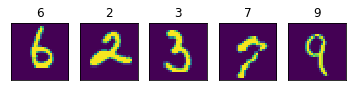

In [13]:
plot_example(inputs, labels)

In [14]:
# check class balance
# sort of equivalent to pandas' value_counts()
Counter(test.y)

Counter({8: 101,
         4: 88,
         7: 103,
         0: 95,
         6: 97,
         2: 95,
         3: 119,
         9: 108,
         5: 90,
         1: 104})

## Define model architecture

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=4)  # colour channels, number of kernels, kernel size
        self.conv2 = nn.Conv2d(6, 16, kernel_size=4)  # input channels must match output of previous conv
        self.fc1 = nn.Linear(16 * 4 * 4, 50)  # how do we calculate this?
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)  # convolution -> relu -> pool
        x = F.max_pool2d(F.relu(F.dropout2d(self.conv2(x))), kernel_size=2, stride=2)  # second layer with dropout
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [16]:
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=.9)

### Training loop

In [17]:
for epoch in range(5):  # loop over the dataset multiple times
    
    # turns on dropout
    net.train()

    for data in tqdm(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        
        # turn off dropout
        net.eval()
        predictions = np.array([])
        # iterate over all batches in test set
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs).to('cpu')
            _, batch_predictions = torch.max(outputs.data, 1)
            predictions = np.hstack((predictions, batch_predictions.numpy()))
            
        print(f'Epoch #{epoch+1} test accuracy: {(y_test == predictions).mean():.3f}')
    

print('Finished Training')


Epoch #1 test accuracy: 0.949



Epoch #2 test accuracy: 0.939



Epoch #3 test accuracy: 0.941



Epoch #4 test accuracy: 0.945



Epoch #5 test accuracy: 0.945
Finished Training


### Testing

In [18]:
# iterate over all batches in test set
y_true = np.array([])
y_pred = np.array([])

# turn off gradients for validation, saves memory and computations
with torch.no_grad():

    # turn off dropout
    net.eval()

    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs).to('cpu')
        
        _, batch_predictions = torch.max(outputs.data, 1)
        y_pred = np.hstack((y_pred, batch_predictions.numpy()))
        y_true = np.hstack((y_pred, labels.to('cpu').numpy()))

print('Test accuracy:', (y_test == y_pred).mean())

Test accuracy: 0.951
